## Dataset information:

### classes: edible=e, poisonous=p

### cap-shape: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s

### cap-surface: fibrous=f, grooves=g, scaly=y, smooth=s

### cap-color: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y

### bruises: bruises=t, no=f

### odor: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p ,spicy=s

### gill-attachment: attached=a, descending=d, free=f, notched=n

### gill-spacing: close=c, crowded=w, distant=d

### gill-size: broad=b, narrow=n

### gill-color: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y

### stalk-shape: enlarging=e, tapering=t

### stalk-root: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?

### stalk-surface-above-ring: fibrous=f, scaly=y, silky=k, smooth=s

### stalk-surface-below-ring: fibrous=f, scaly=y, silky=k, smooth=s

### stalk-color-above-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y

### stalk-color-below-ring: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y

### veil-type: partial=p, universal=u

### veil-color: brown=n, orange=o, white=w, yellow=y

### ring-number: none=n, one=o, two=t

### ring-type: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z

### spore-print-color: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y

### population: abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y

### habitat: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

In [1]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.contrib.layers as layers
from tqdm import tqdm
import re
import json

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)


# # # Voor GPU support
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Inlezen van de dataset

dataset = pd.read_csv('./Dataset/mushrooms.csv')

# Print de eerste 5 lijnen van de dataset
dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [3]:
# Controleren op null values
dataset.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [4]:
# Momenteel bestaat de data uit verschillende letters per kolom wat moeilijk te begrijpen is
# Met de get_dummies function zorgen we ervoor dat we onze kolommen one-hot encoden
data_dum = pd.get_dummies(dataset)

# Print de shape van de one-hot encoded data
data_dum.shape

(8124, 119)

In [5]:
# Print de eerste 5 lijnen van de one-hot encoded data
# Hierin kunnen we zien dat we nu veel meer kolommen hebben en de letters weg zijn
data_dum.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-shape_e,stalk-shape_t,stalk-root_?,stalk-root_b,stalk-root_c,stalk-root_e,stalk-root_r,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_b,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_b,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:xlabel='class', ylabel='count'>

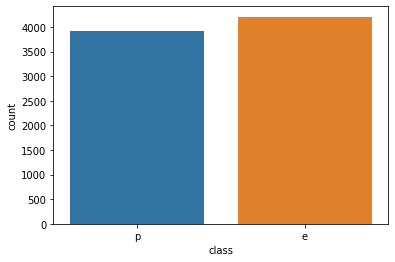

In [6]:
# Controleren of de dataset gebalanceerd is
sns.countplot(x="class", data=dataset)

## Gebalanceerdheid
### We zien dat de data redelijk goed gebalanceerd is en dat we een kleine meerderheid hebben van paddenstoelen die eetbaar zijn vs. de giftige paddenstoelen

In [7]:
# Definiëer X en Y

# In onze x_data willen we alle data behalve of de paddenstoel eetbaar is of niet dus nemen we alle kolommen na deze 2
# We zetten dit ook om naar een numpy-array met type float
X_data = data_dum.loc[:, 'cap-shape_b':].to_numpy().astype(np.float32)


# In onze y_data mogen we enkel de klasses p en e (poisonous & edible) hebben
# We zetten dit ook om naar een numpy-array met type float
y_data = data_dum.loc[:, :'class_p'].to_numpy().astype(np.float32)


In [8]:
# We definiëren dat de trainingset 5000 samples moet zijn
n = 5000

# Neem de eerste 5000 samples van de x_data en steek deze in X_train
X_train = X_data[:n]

# Onze testset X_test krijgt de overige ~3000 samples
X_test = X_data[n:]

# Neem de eerste 5000 samples van de y_data en steek deze in y_train
y_train = y_data[:n]

# Onze testset y_test krijgt de overige ~3000 samples
y_test = y_data[n:]

In [9]:
# Print de shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5000, 117)
(3124, 117)
(5000, 2)
(3124, 2)


In [10]:
# Definiëer de INPUT_SIZE met het aantal kolommen dat X_train heeft
INPUT_SIZE = X_train.shape[1]

# Definiëer de OUTPUT_SIZE met het aantal kolommen dat y_train heeft
OUTPUT_SIZE = y_train.shape[1]

# Definiëer EPOCHS_NUM, het aantal epochs dat het model moet doorlopen
EPOCH_NUM = 50

# Definiëer de BATCH_SIZE dat het model moet gebruiken
BATCH_SIZE = 256

In [11]:
# Maak een placeholder aan met het datatype en de shape voor de inputs
inputs = tf.placeholder(tf.float32, shape=[None, INPUT_SIZE])

# Maak een placeholder aan met het datatype en de shape voor de outputs
outputs = tf.placeholder(tf.float32, shape=[None, OUTPUT_SIZE])

In [12]:
# Maak een nieuwe variabele waarin we een truncated value maken om saturatie te voorkomen waardoor de neuroon niet meer zou bijleren
w = tf.Variable(tf.truncated_normal([INPUT_SIZE, OUTPUT_SIZE], stddev=0.1), dtype=tf.float32)

# Maak een nieuwe variabele waarin we een constante tensor aanmaken
b = tf.Variable(tf.constant(0.1, shape=[OUTPUT_SIZE]), dtype=tf.float32)

# Bereken de y_pred
y_pred = tf.matmul(inputs, w) + b

# Maak de de loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=outputs, logits=y_pred))

# Laat de Adam Optimizer de train step aanpassen
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

# Definiëer hoe de juiste prediction gevonden wordt
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(outputs, 1))

# Definiëer hoe de accuracy berekend wordt
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Maak een nieuwe Session
sess = tf.Session()

# Maak een saver om het model op te slaan
saver = tf.train.Saver()

# Run de session met de globale variabelen
sess.run(tf.global_variables_initializer())

# Blijf de for-loop uitvoeren tot het meegegeven aantal epochs is uitgevoerd
for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
    # Maak een willekeurige permutatie in onze range van 5000 (n)
    perm = np.random.permutation(n)
    print(perm)

    prev_test_acc = 0

    for i in range(0, n, BATCH_SIZE):
        # Definiëer de X_batch via de eerder gekozen permutatie
        X_batch = X_train[perm[i:i+BATCH_SIZE]]

        # Definiëer de y_batch via de eerder gekozen permutatie
        y_batch = y_train[perm[i:i+BATCH_SIZE]]

        # Run de train (adam)
        train_step.run(session=sess, feed_dict={inputs: X_batch, outputs: y_batch})
    
    # Evalueer de accuracy op de training data
    acc = accuracy.eval(session=sess, feed_dict={inputs: X_train, outputs: y_train})

    # Evalueer de accuracy op de test data
    test_acc = accuracy.eval(session=sess, feed_dict={inputs: X_test, outputs: y_test})

    # Print de accuracy en validation accuracy elke epoch
    if (epoch+1) % 1 == 0:
        tqdm.write('epoch:\t%i\taccuracy:\t%f\tvalidation accuracy:\t%f' % (epoch+1, acc, test_acc))

        # Definiëer het path naar waar het model gesaved moet worden en save het
        if (test_acc > prev_test_acc):
            save_path = saver.save(sess, './Models/model.ckpt')
            print("Model saved in path: %s" % save_path)
            prev_test_acc = test_acc

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch:	1	accuracy:	0.693400	validation accuracy:	0.825544
  0%|          | 0/50 [00:00<?, ?it/s]Model saved in path: ./Models/model.ckpt
epoch:	2	accuracy:	0.802600	validation accuracy:	0.785211
  2%|▏         | 1/50 [00:00<00:13,  3.71it/s]Model saved in path: ./Models/model.ckpt
epoch:	3	accuracy:	0.868600	validation accuracy:	0.805378
  4%|▍         | 2/50 [00:00<00:12,  3.97it/s]Model saved in path: ./Models/model.ckpt
epoch:	4	accuracy:	0.913600	validation accuracy:	0.850832
  6%|▌         | 3/50 [00:00<00:12,  3.63it/s]Model saved in path: ./Models/model.ckpt
epoch:	5	accuracy:	0.923200	validation accuracy:	0.869078
  8%|▊         | 4/50 [00:01<00:12,  3.80it/s]Model saved in path: ./Models/model.ckpt
epoch:	6	accuracy:	0.927000	validation accuracy:	0.873239
 10%|█         | 5/50 [00:01<00:11

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=5000, random_state=0)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(117,)),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
	tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 117)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               11800     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 22,102
Trainable params: 22,102
Non-trainable params: 0
_________________________________________________________________


In [15]:
# pas earlystopping toe
earlystopper = EarlyStopping(patience=20, verbose=1)

# sla het beste model op
checkpointer = ModelCheckpoint('./Models/model_keras.h5', verbose=1, save_best_only=True)

# train het model
history = model.fit(X_train, y_train, epochs=10, verbose=1, batch_size=256, validation_data=(X_test, y_test), callbacks=[earlystopper, checkpointer])


Train on 3124 samples, validate on 5000 samples
Epoch 1/10
3072/3124 [============================>.] - ETA: 0s - loss: 0.5996 - acc: 0.7747
Epoch 00001: val_loss improved from inf to 0.44734, saving model to ./Models/model_keras.h5
3124/3124 [==============================] - 1s 175us/sample - loss: 0.5970 - acc: 0.7774 - val_loss: 0.4473 - val_acc: 0.9051
Epoch 2/10
2304/3124 [=====================>........] - ETA: 0s - loss: 0.3779 - acc: 0.8969
Epoch 00002: val_loss improved from 0.44734 to 0.22270, saving model to ./Models/model_keras.h5
3124/3124 [==============================] - 0s 60us/sample - loss: 0.3508 - acc: 0.8990 - val_loss: 0.2227 - val_acc: 0.9194
Epoch 3/10
2304/3124 [=====================>........] - ETA: 0s - loss: 0.1899 - acc: 0.9321
Epoch 00003: val_loss improved from 0.22270 to 0.10155, saving model to ./Models/model_keras.h5
3124/3124 [==============================] - 0s 55us/sample - loss: 0.1702 - acc: 0.9419 - val_loss: 0.1016 - val_acc: 0.9738
Epoch 4/10

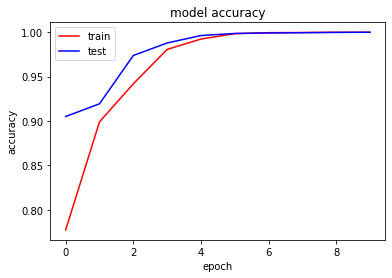

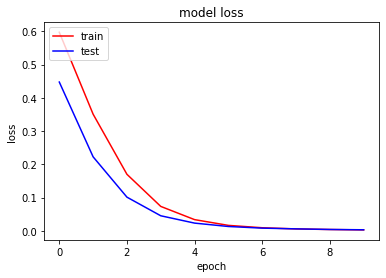

In [16]:
# Plot of the training history

# Accuracy
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
rounded_labels=np.argmax(y_test, axis=1)


In [18]:
# Testen met de test set
# model = tf.keras.models.load_model('./Models/model_keras.h5')

y_pred = model.predict_classes(X_test)
print('\n')
print(classification_report(rounded_labels, y_pred))
print('\n')
cf = confusion_matrix(rounded_labels, y_pred)
print(accuracy_score(rounded_labels, y_pred) * 100)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2618
           1       1.00      1.00      1.00      2382

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



100.0


In [19]:
y_pred = model.predict(X_test)
print('MAE: %f' % (mean_absolute_error(y_pred, y_test)))
print('R2: %f' % (r2_score(y_pred, y_test))) 

MAE: 0.003258
R2: 0.998662


In [39]:
test_array_poison = np.array([[1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0]])

test_array_edible = np.array([[0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0]])

print(test_array_poison.shape)
print(test_array_edible.shape)

(1, 117)
(1, 117)


In [34]:
model.predict(test_array_poison)

array([[0.00549532, 0.99673945]], dtype=float32)

In [38]:
model.predict(test_array_edible)

array([[9.9964821e-01, 1.7352478e-04]], dtype=float32)

In [40]:
model.predict(test_array_edible)

array([[9.9964166e-01, 1.6139307e-04]], dtype=float32)